In [25]:
%load_ext autoreload
%autoreload 2
from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image, match_pair, numpy_image_to_torch
from lightglue import viz2d
from pathlib import Path
import torch
import time
import cv2
import numpy as np
import math
images = Path('uavimg')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
extractor = SuperPoint(max_num_keypoints=2048, nms_radius=3).eval().cuda()  # load the extractor
match_conf = {
    'width_confidence': 0.99,  # for point pruning
    'depth_confidence': 0.95,  # for early stopping,
}
matcher = LightGlue(pretrained='superpoint', **match_conf).eval().cuda()

Loaded SuperPoint model
Loaded LightGlue model


In [27]:
def rotateP(angle,valuex,valuey,pointx,pointy):
    valuex = np.array(valuex)
    valuey = np.array(valuey)
    sRotatex = (valuex-pointx)*math.cos(angle) + (valuey-pointy)*math.sin(angle) + pointx
    sRotatey = (valuey-pointy)*math.cos(angle) - (valuex-pointx)*math.sin(angle) + pointy
    return sRotatex,sRotatey

print(rotateP(math.radians(90), 2, 2, 1, 1))

(2.0, 1.1102230246251565e-16)


In [32]:
def rotate(image, angle, center=None, scale=1.0): #逆时针旋转
    (h, w) = image.shape[:2] #2
    if center is None: #3
        center = (w // 2, h // 2) #4
 
    M = cv2.getRotationMatrix2D(center, angle, scale) #5
 
    rotated = cv2.warpAffine(image, M, (w, h)) #6
    return rotated #7

image0 = cv2.imread('uavimg/query.png', cv2.IMREAD_COLOR)[...,::-1]
image1 = cv2.imread('uavimg/r2.png', cv2.IMREAD_COLOR)[...,::-1]

sat0 = image0
sat1 = rotate(image0, 90)
sat2 = rotate(image0, 180)
sat3 = rotate(image0, 270)

In [23]:
a = 1
b = 2
c = 3
d = [a, b, c]
print(d.index(b))

1


506


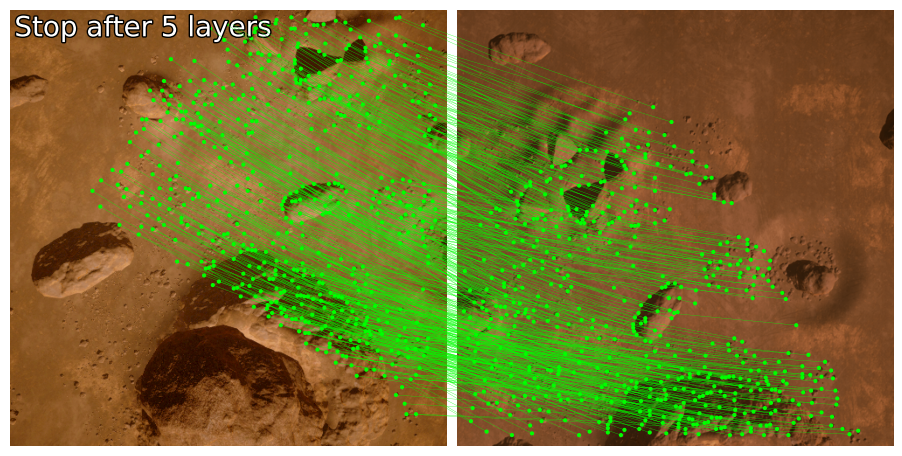

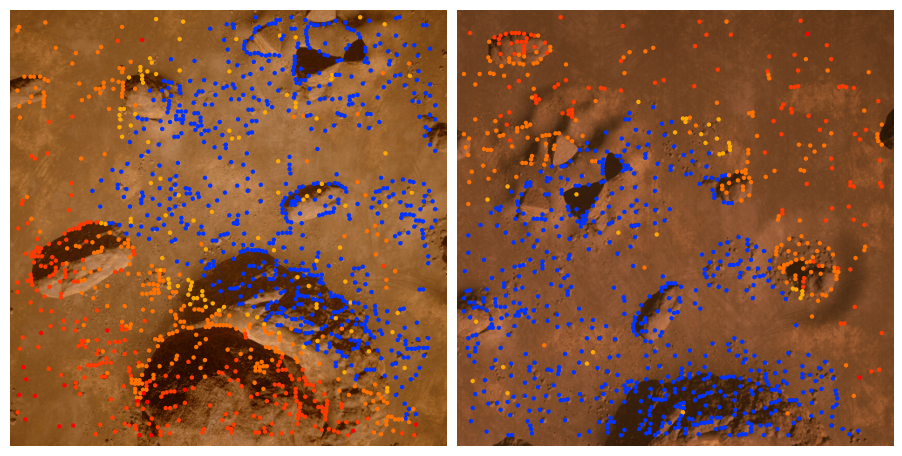

In [31]:
image0, scales0 = load_image(images / 'query.png', grayscale=False)
image1, scales1 = load_image(images / 'r2.png', grayscale=False)

t1 = time.time()
pred = match_pair(extractor, matcher, image0, image1)
t2 = time.time()

kpts0, kpts1, matches = pred['keypoints0'], pred['keypoints1'], pred['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {pred["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(pred['prune0']), viz2d.cm_prune(pred['prune1'])
viz2d.plot_images([image0.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
print(len(m_kpts0))

25


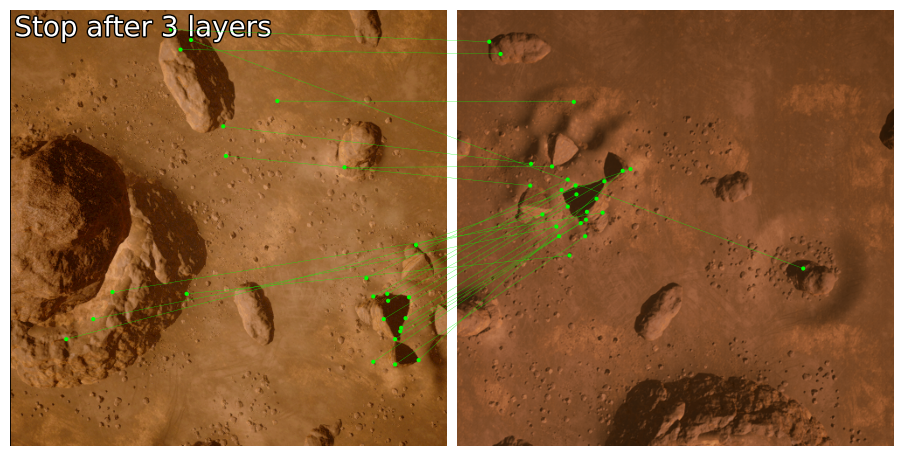

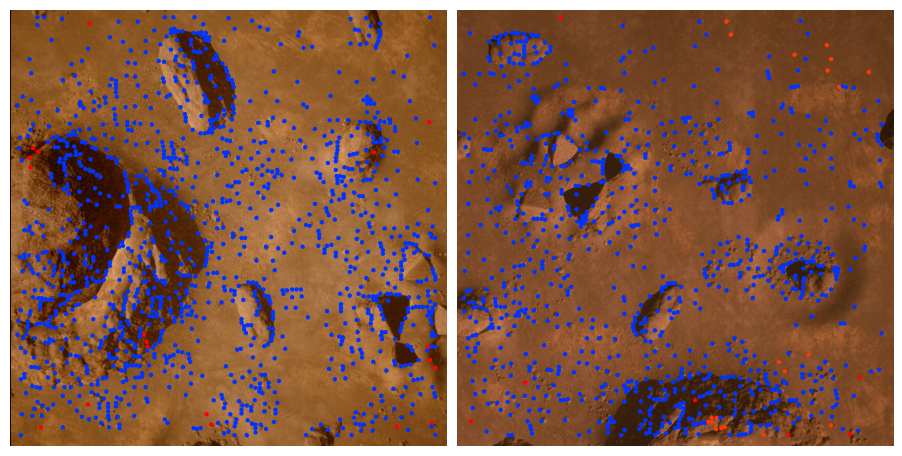

In [33]:
# image0, scales0 = load_image(images / 'sat.png', grayscale=False)
# image1, scales1 = load_image(images / 'uav.png', grayscale=False)

# image0 = cv2.imread('uavimg/sat.png', cv2.IMREAD_COLOR)[...,::-1]
# image1 = cv2.imread('uavimg/uav.png', cv2.IMREAD_COLOR)[...,::-1]

sat0 = numpy_image_to_torch(sat0)
sat1 = numpy_image_to_torch(sat1)
sat2 = numpy_image_to_torch(sat2)
sat3 = numpy_image_to_torch(sat3)

sat = sat3

image1 = numpy_image_to_torch(image1)


t1 = time.time()
pred = match_pair(extractor, matcher, sat, image1)
t2 = time.time()

kpts0, kpts1, matches = pred['keypoints0'], pred['keypoints1'], pred['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([sat.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {pred["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(pred['prune0']), viz2d.cm_prune(pred['prune1'])
viz2d.plot_images([sat.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
print(len(m_kpts0))

386


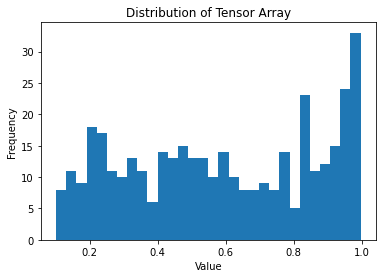

In [19]:
import matplotlib.pyplot as plt

matching_scores = pred['matching_scores']
print(len(matching_scores))

plt.hist(matching_scores, bins=30)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Tensor Array')
plt.show()

In [20]:
scores = matching_scores.numpy()
print(scores.mean())

0.58714855


In [21]:
import cv2 

H, _ = cv2.findHomography(m_kpts0.numpy(), m_kpts1.numpy(), cv2.RANSAC, 5.0)


plt.imshow(image0.permute(1,2,0))
plt.show()
plt.imshow(image1.permute(1,2,0))
plt.show()


image2 = cv2.warpPerspective(image0.permute(1,2,0).numpy(), H, (image1.permute(1,2,0).shape[1], image1.permute(1,2,0).shape[0]))
plt.imshow(image2)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'permute'